In [25]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib_venn import venn2 

### Comparison MS data v1

In [15]:
dataset1 = "deybis_05" # "deybis_05", "vanessa_05", "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset
dataset2 = "vanessa_05" # "deybis_05", "vanessa_05", "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset

encoder = "GIN"


In [ ]:
list_train_set = [
	["FrescoAmazonas_1", "FrescoAmazonas_2"],
	["FrescoCusco_1", "FrescoCusco_2"],
	["FrescoSanMartin_1", "FrescoSanMartin_2"],
	["SecoAmazonas_1", "SecoAmazonas_2"],
	["SecoCusco_1", "SecoCusco_2"],
	["SecoSanMartin_1", "SecoSanMartin_2"]
]

In [ ]:
tol_rt, tol_mz = 0.5, 15 # 0.5 min, 10 ppm

for train_set in list_train_set:
	df_1 = pd.read_csv(f"data/{dataset1}/output/node_alignment_{encoder}_{dataset1}_{train_set}.csv" , sep=";", decimal=",")
	df_2 = pd.read_csv(f"data/{dataset2}/output/node_alignment_{encoder}_{dataset2}_{train_set}.csv" , sep=";", decimal=",")

	df_match = (
		df_1.assign(key=1)
			.merge(df_2.assign(key=1), on="key", suffixes=("_1", "_2"))
			.drop(columns="key")
	)

	df_match["mz_error"] = (
		(df_match["Average Mz_1"] - df_match["Average Mz_2"]).abs() /
		((df_match["Average Mz_1"] + df_match["Average Mz_2"]) / 2)
	) * 1e6

	df_match["rt_error"] = (df_match["Average Rt_1"] - df_match["Average Rt_2"]).abs()
	df_match

	df_match_filter = df_match[df_match["mz_error"] < tol_mz]
	# df_match_filter = df_match[(df_match["mz_error"] < tol_mz) & (df_match["rt_error"] < tol_rt)]
	
	print(train_set)
	display(df_match_filter)

['FrescoAmazonas_1', 'FrescoAmazonas_2']


,Id_1,Average Rt_1,Average Mz_1,Metabolite name_1,Id_2,Average Rt_2,Average Mz_2,Metabolite name_2,mz_error,rt_error


['FrescoCusco_1', 'FrescoCusco_2']


,Id_1,Average Rt_1,Average Mz_1,Metabolite name_1,Id_2,Average Rt_2,Average Mz_2,Metabolite name_2,mz_error,rt_error
3356,282,7.369,327.00706,BIS(TRIMETHYLSILYLMETHYL) SULFIDE; EI-B; MS,442,19.382,327.00874,NaN,5.137491,12.013
32165,1678,24.495,327.00652,Unknown,442,19.382,327.00874,NaN,6.788832,5.113


['FrescoSanMartin_1', 'FrescoSanMartin_2']


,Id_1,Average Rt_1,Average Mz_1,Metabolite name_1,Id_2,Average Rt_2,Average Mz_2,Metabolite name_2,mz_error,rt_error
3887,282,7.369,327.00706,BIS(TRIMETHYLSILYLMETHYL) SULFIDE; EI-B; MS,442,19.382,327.00874,NaN,5.137491,12.013
24245,1191,18.013,251.18527,Unknown,217,9.137,251.18581,NaN,2.149805,8.876
48209,374,8.076,327.01132,"1,4-BIS(TRIMETHYLSILYL)BENZENE; EI-B; MS",442,19.382,327.00874,NaN,7.889666,11.306


['SecoAmazonas_1', 'SecoAmazonas_2']


,Id_1,Average Rt_1,Average Mz_1,Metabolite name_1,Id_2,Average Rt_2,Average Mz_2,Metabolite name_2,mz_error,rt_error
1180,374,8.076,327.01132,"1,4-BIS(TRIMETHYLSILYL)BENZENE; EI-B; MS",442,19.382,327.00874,NaN,7.889666,11.306


['SecoCusco_1', 'SecoCusco_2']


,Id_1,Average Rt_1,Average Mz_1,Metabolite name_1,Id_2,Average Rt_2,Average Mz_2,Metabolite name_2,mz_error,rt_error
43744,36,6.154,281.06985,Unknown,41,2.1,281.07077,sulfalene,3.273202,4.054


['SecoSanMartin_1', 'SecoSanMartin_2']


,Id_1,Average Rt_1,Average Mz_1,Metabolite name_1,Id_2,Average Rt_2,Average Mz_2,Metabolite name_2,mz_error,rt_error
11568,1191,18.013,251.18527,Unknown,217,9.137,251.18581,NaN,2.149805,8.876
31698,1538,22.373,281.07199,Unknown,41,2.100,281.07077,sulfalene,4.340534,20.273
33606,1760,25.762,341.16177,Unknown,313,11.951,341.15778,"3,8,15-Trihydroxy-12,13-epoxytrichothec-9-en-4...",11.695400,13.811


In [ ]:
tol_rt, tol_mz = 0.5, 15 # 0.5 min, 10 ppm

df_1 = pd.read_csv(f"data/{dataset1}/raw.csv", index_col=0).iloc[:, :3] # Sep
df_2 = pd.read_csv(f"data/{dataset2}/raw.csv", index_col=0).iloc[:, :3] # Dec
print(len(df_1), len(df_2))

df_match = (
	df_1.assign(key=1)
		.merge(df_2.assign(key=1), on="key", suffixes=("_1", "_2"))
		.drop(columns="key")
)

df_match["mz_error"] = (
	(df_match["Average Mz_1"] - df_match["Average Mz_2"]).abs() /
	((df_match["Average Mz_1"] + df_match["Average Mz_2"]) / 2)
) * 1e6

df_match["rt_error"] = (df_match["Average Rt_1"] - df_match["Average Rt_2"]).abs()
df_match

2072 559


,Average Rt_1,Average Mz_1,Metabolite name_1,Average Rt_2,Average Mz_2,Metabolite name_2,mz_error,rt_error
0,6.068,159.99556,Unknown,0.089,165.99460,NaN,3.680504e+04,5.979
1,6.068,159.99556,Unknown,0.090,158.01272,"[Similar to: 1-benzylhexahydropyrimidine-2,4,6...",1.247037e+04,5.978
2,6.068,159.99556,Unknown,0.097,172.95681,NaN,7.785648e+04,5.971
3,6.068,159.99556,Unknown,0.191,167.01326,NaN,4.292055e+04,5.877
4,6.068,159.99556,Unknown,0.196,165.98329,NaN,3.673692e+04,5.872
...,...,...,...,...,...,...,...,...
1158243,30.948,57.09591,Unknown,29.965,341.26686,Docosahexaenoic acid,1.426694e+06,0.983
1158244,30.948,57.09591,Unknown,29.966,178.15937,N-Propylamphetamine,1.029209e+06,0.982
1158245,30.948,57.09591,Unknown,29.969,707.49253,NaN,1.701299e+06,0.979
1158246,30.948,57.09591,Unknown,29.969,165.11386,2-piperazinopyrimidine,9.722160e+05,0.979


In [19]:
df_match_filter = df_match[df_match["mz_error"] < tol_mz]
df_match_filter

,Average Rt_1,Average Mz_1,Metabolite name_1,Average Rt_2,Average Mz_2,Metabolite name_2,mz_error,rt_error
20165,6.154,281.06985,Unknown,2.100,281.07077,sulfalene,3.273202,4.054
66404,6.428,327.00684,Unknown,19.382,327.00874,NaN,5.810259,12.954
79472,6.502,121.06599,BENZALDEHYDE DIMETHYL ACETAL; EI-B; MS,2.350,121.06526,Acetophenone,6.029788,4.152
148735,7.271,281.07272,Unknown,2.100,281.07077,sulfalene,6.937730,5.171
152490,7.294,327.00545,Unknown,19.382,327.00874,NaN,10.060944,12.088
158080,7.369,327.00706,BIS(TRIMETHYLSILYLMETHYL) SULFIDE; EI-B; MS,19.382,327.00874,NaN,5.137491,12.013
205411,8.001,489.09079,Unknown,9.825,489.09637,NaN,11.408860,1.824
209508,8.076,327.01132,"1,4-BIS(TRIMETHYLSILYL)BENZENE; EI-B; MS",19.382,327.00874,NaN,7.889666,11.306
346107,10.403,180.10386,BENZYL OXALATE; EI-B; MS,2.298,180.10229,Salsolinol,8.717230,8.105
346126,10.403,180.10386,BENZYL OXALATE; EI-B; MS,2.359,180.10227,Salsolinol,8.828278,8.044


In [20]:
df_match_filter = df_match[(df_match["mz_error"] < tol_mz) & (df_match["rt_error"] < tol_rt)]
df_match_filter

,Average Rt_1,Average Mz_1,Metabolite name_1,Average Rt_2,Average Mz_2,Metabolite name_2,mz_error,rt_error


In [ ]:
""" rt_diff = (df_match["Average Rt_1"] - df_match["Average Rt_2"]).abs()
mz_diff = (
	((df_match["Average Mz_1"] - df_match["Average Mz_2"]).abs() / (df_match["Average Mz_1"] + df_match["Average Mz_2"]) / 2)
) * 1e6
mask = (rt_diff <= tol_rt) & (mz_diff <= tol_mz)
# mask = (mz_diff <= tol_mz)

df_intersection = df_match.loc[mask].reset_index(drop=True)
df_intersection """

' rt_diff = (df_match["Average Rt_1"] - df_match["Average Rt_2"]).abs()\nmz_diff = (\n    ((df_match["Average Mz_1"] - df_match["Average Mz_2"]).abs() / (df_match["Average Mz_1"] + df_match["Average Mz_2"]) / 2)\n) * 1e6\nmask = (rt_diff <= tol_rt) & (mz_diff <= tol_mz)\n# mask = (mz_diff <= tol_mz)\n\ndf_intersection = df_match.loc[mask].reset_index(drop=True)\ndf_intersection '

In [ ]:
""" tol_rt, tol_mz = 0.5, 0.01 # Change

for train_set in list_train_set:
	df_1 = pd.read_csv(f"data/{dataset1}/output/node_alignment_{encoder}_{dataset1}_{train_set}.csv" , sep=";", decimal=",")
	df_2 = pd.read_csv(f"data/{dataset2}/output/node_alignment_{encoder}_{dataset2}_{train_set}.csv" , sep=";", decimal=",")

	df_match = (
		df_1.assign(key=1)
			.merge(df_2.assign(key=1), on="key", suffixes=("_1", "_2"))
			.drop(columns="key")
	)

	rt_diff = (df_match["Average Rt_1"] - df_match["Average Rt_2"]).abs()
	mz_diff = (
		(df_match["Average Mz_1"] - df_match["Average Mz_2"]).abs() # / df_match["Average Mz_2"] * 1e6
	)
	# mask = (rt_diff <= tol_rt) & (mz_diff <= tol_mz)
	mask = (mz_diff <= tol_mz)

	df_intersection = df_match.loc[mask].reset_index(drop=True)
	print(train_set)
	display(df_intersection) """

' tol_rt, tol_mz = 0.5, 0.01 # Change\n\nfor train_set in list_train_set:\n\tdf_1 = pd.read_csv(f"data/{dataset1}/output/node_alignment_{encoder}_{dataset1}_{train_set}.csv" , sep=";", decimal=",")\n\tdf_2 = pd.read_csv(f"data/{dataset2}/output/node_alignment_{encoder}_{dataset2}_{train_set}.csv" , sep=";", decimal=",")\n\n\tdf_match = (\n\t\tdf_1.assign(key=1)\n\t\t\t.merge(df_2.assign(key=1), on="key", suffixes=("_1", "_2"))\n\t\t\t.drop(columns="key")\n\t)\n\n\trt_diff = (df_match["Average Rt_1"] - df_match["Average Rt_2"]).abs()\n\tmz_diff = (\n\t\t(df_match["Average Mz_1"] - df_match["Average Mz_2"]).abs() # / df_match["Average Mz_2"] * 1e6\n\t)\n\t# mask = (rt_diff <= tol_rt) & (mz_diff <= tol_mz)\n\tmask = (mz_diff <= tol_mz)\n\n\tdf_intersection = df_match.loc[mask].reset_index(drop=True)\n\tprint(train_set)\n\tdisplay(df_intersection) '

### Comparison filter Deybis

In [6]:
dataset1 = "deybis_filter_september_05" # "deybis_filter_september_05", "deybis_filter_december_05", "deybis_05", "vanessa_05", "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset
dataset2 = "deybis_filter_december_05" # "deybis_filter_september_05", "deybis_filter_december_05",

# Parameters data
file = open(f"data/{dataset1}/input/parameters.json")
params = json.load(file)

methods = params["methods"]
print("Methods:\t", methods)

data_variations = params["data_variations"]
print("Data variations:", data_variations)

has_transformation = params["has_transformation"]
print("Has transformation:", has_transformation)

dimension = params["dimension"]
print("Dimension:\t", dimension)

threshold_corr = params["threshold_corr"]
print("Threshold corr:\t", threshold_corr)

iterations = params["iterations"]
print("Iterations:\t", iterations)

groups_id = params["groups_id"]
print("Groups id:\t", groups_id)

subgroups_id = params["subgroups_id"]
print("Subgroups id:\t", subgroups_id)

groups_id_no = params["groups_id_no"]
print("Groups id (no):\t", groups_id_no)

seeds = params["seeds"]
print("Seeds:\t\t", seeds)

sensitivity = params["sensitivity"]
print("Sensitivity:\t", sensitivity)

Methods:	 ['t-gae']
Data variations: ['none']
Has transformation: False
Dimension:	 32
Threshold corr:	 0.5
Iterations:	 1
Groups id:	 ['SecoAmazonas', 'SecoCusco', 'SecoSanMartin', 'FrescoAmazonas', 'FrescoCusco', 'FrescoSanMartin']
Subgroups id:	 {'SecoAmazonas': ['1', '2'], 'SecoCusco': ['1', '2'], 'SecoSanMartin': ['1', '2'], 'FrescoAmazonas': ['1', '2'], 'FrescoCusco': ['1', '2'], 'FrescoSanMartin': ['1', '2']}
Groups id (no):	 ['Blank', 'QC', 'Std']
Seeds:		 [41, 42, 43, 44, 45, 46]
Sensitivity:	 False


In [9]:
# Read raw data

df_join_raw = pd.read_csv("data/{}/input/raw.csv".format(dataset1), index_col=0)
df_join_raw

,Average Rt,Average Mz,Metabolite name,SecoAmazonas_1.1,SecoAmazonas_1.2,SecoAmazonas_1.3,FrescoSanMartin_1.1,FrescoSanMartin_1.2,FrescoSanMartin_1.3,FrescoSanMartin_2.1,...,SecoSanMartin_2.3,SecoCusco_1.1,SecoCusco_1.2,SecoCusco_1.3,SecoCusco_2.1,SecoCusco_2.2,SecoCusco_2.3,FrescoAmazonas_2.1,FrescoAmazonas_2.2,FrescoAmazonas_2.3
0,1.754,167.01318,unknown,2.102369e+07,5.191424e+06,2.297892e+06,3.229474e+07,3.107148e+07,5.171922e+06,2.880494e+07,...,1.720800e+06,5.260539e+06,5.884508e+06,2.032107e+06,4.365939e+06,5.541052e+06,1.244700e+06,3.412579e+07,1.300488e+07,7.499824e+06
1,2.120,152.05702,unknown,2.420068e+06,2.307995e+06,5.114995e+06,5.664406e+05,6.075747e+05,9.785619e+05,6.388311e+05,...,9.573049e+05,1.771467e+06,1.866798e+06,3.887925e+06,1.728809e+06,1.752814e+06,3.559701e+06,7.633949e+05,7.586965e+05,1.544267e+06
2,2.125,257.96816,unknown,9.001219e+06,9.873734e+06,7.146516e+05,1.099685e+07,1.102387e+07,7.044592e+05,1.529399e+07,...,1.038209e+06,1.003099e+07,1.058112e+07,5.771471e+05,1.331955e+07,1.382660e+07,8.397252e+05,9.151868e+06,9.999602e+06,1.219800e+06
3,2.128,207.98572,unknown,1.938034e+07,2.008965e+07,2.191925e+06,2.779337e+07,2.368245e+07,2.417852e+06,2.770186e+07,...,1.879193e+06,1.891332e+07,1.875001e+07,1.680360e+06,2.098740e+07,2.042521e+07,1.437406e+06,2.369094e+07,2.617182e+07,3.319935e+06
4,2.133,217.96001,unknown,9.418357e+06,9.172249e+06,1.434368e+07,1.256749e+07,1.200879e+07,1.610727e+07,1.448343e+07,...,2.158761e+07,9.322098e+06,9.037713e+06,1.298658e+07,1.090200e+07,1.103374e+07,1.543508e+07,1.196644e+07,1.212436e+07,2.462687e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,20.487,501.26053,unknown,5.709668e+06,5.691558e+06,4.908186e+06,8.214671e+06,8.060828e+06,7.154128e+06,6.951144e+06,...,6.457166e+06,5.127135e+06,4.955646e+06,4.566583e+06,4.639459e+06,4.602868e+06,3.850485e+06,8.845150e+06,9.611742e+06,8.629254e+06
158,22.679,520.34109,unknown,1.034447e+07,1.153674e+07,3.173041e+07,1.338164e+06,1.248430e+06,4.271653e+06,3.965387e+05,...,3.035556e+07,1.844937e+07,1.903460e+07,5.936571e+07,1.951251e+07,1.939011e+07,5.120970e+07,5.499485e+05,5.482506e+05,1.901125e+06
159,23.180,200.20136,unknown,7.190209e+06,6.419463e+06,1.939271e+07,9.675436e+06,9.527342e+06,3.067538e+07,9.600671e+06,...,2.646694e+07,5.868539e+06,6.047440e+06,1.754588e+07,5.603531e+06,6.290763e+06,1.664977e+07,1.037119e+07,1.042731e+07,3.352375e+07
160,24.234,496.34082,unknown,2.836296e+07,2.610888e+07,5.500906e+07,3.428636e+07,3.042322e+07,6.613276e+07,2.900143e+07,...,5.965081e+07,2.516866e+07,2.516913e+07,5.005681e+07,2.480254e+07,2.506261e+07,4.261884e+07,3.936421e+07,3.870481e+07,7.023319e+07


SecoAmazonas


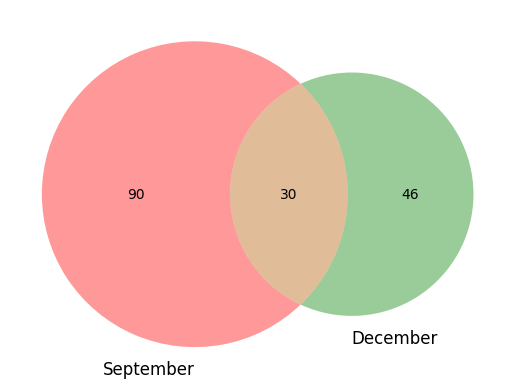

SecoCusco


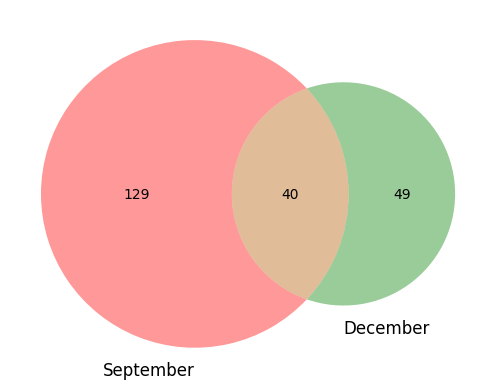

SecoSanMartin


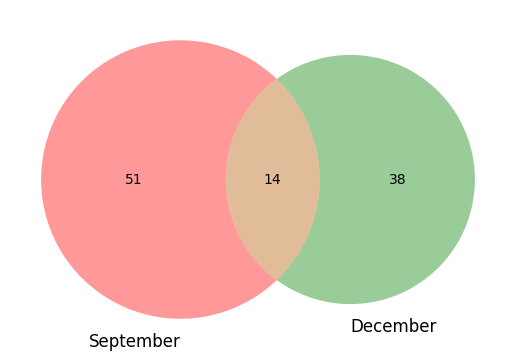

FrescoAmazonas


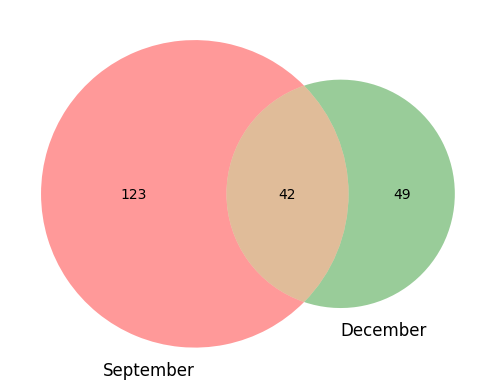

FrescoCusco


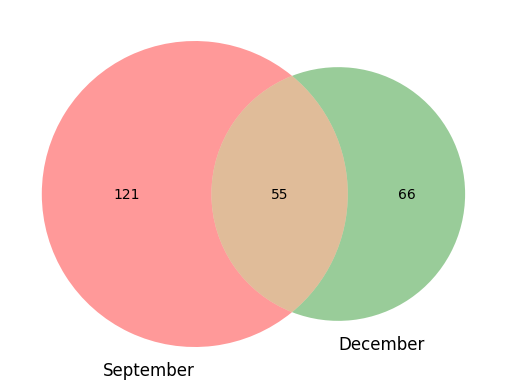

FrescoSanMartin


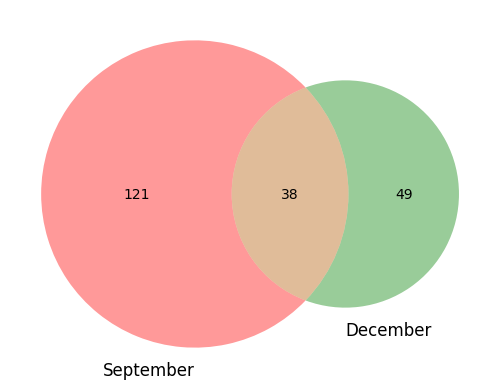

,Group id,Common node id
0,SecoAmazonas,"5,25,30,43,50,52,53,54,56,58,60,61,67,83,90,97..."
1,SecoCusco,"4,5,10,16,37,48,50,53,57,58,61,63,66,67,74,77,..."
2,SecoSanMartin,"14,25,34,39,41,78,82,124,125,154,156,157,159,161"
3,FrescoAmazonas,"3,4,14,18,27,33,35,46,48,50,52,61,63,75,84,88,..."
4,FrescoCusco,"2,10,11,12,13,22,25,26,27,33,35,47,48,50,52,53..."
5,FrescoSanMartin,"4,17,21,25,30,33,35,47,48,50,52,54,61,63,67,69..."


In [28]:
# Filter

list_data = []
for group_id in groups_id:
	print(group_id)

	# Read common node
	common_node_id1 = sorted(np.load(f"data/{dataset1}/output/common_node/{group_id}.npy"))
	common_node_id2 = sorted(np.load(f"data/{dataset2}/output/common_node/{group_id}.npy"))
	# print(common_node_id1)
	# print(common_node_id2)

	intersection = sorted(list(set(common_node_id1) & set(common_node_id2)))
	# print(intersection)
	
	list_data.append([group_id, ",".join(map(str, intersection))])

	# Plot
	plt.figure()
	venn2(subsets=(len(common_node_id1), len(common_node_id2), len(intersection)), set_labels=("September", "December"))
	plt.show()

df_comparison = pd.DataFrame(list_data, columns=["Group id", "Common node id"])
df_comparison